In [1]:
!pip install --upgrade matplotlib > None # need refresh enviroment after installation

In [2]:
!pip install basemap > None

In [146]:
!pip install optuna > None

In [3]:
import optuna

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
from mpl_toolkits.basemap import Basemap

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
%matplotlib inline

# Data cleaning

In [4]:
path = 'data.csv'
data = pd.read_csv(path, delimiter = ';')

In [5]:
grouped_by_year = data.groupby('year')
result_df = pd.DataFrame()

for year, group in grouped_by_year:
    percentages = group.apply(lambda x: x.count() / len(x) * 100)
    result_df = pd.concat([result_df, percentages], axis=1, ignore_index=True)

result_df.columns = grouped_by_year.groups.keys()
pokaz_2019 = result_df[2019]

In [8]:
ok = pokaz_2019 [pokaz_2019 == 100].index
clean = data[data['year']==2019]
clean = clean[ok]

In [9]:
clean1 = clean.drop(['rni','preschool_child'],axis=1)
clean1['workers'] = clean['workers'] / clean['pop_work'] * 100
clean1['pop_work'] = clean['pop_work'] / clean['population'] * 100
clean1['pop_young'] = clean['pop_young'] / clean['population'] * 100
clean1['pop_1_6'] = clean['pop_1_6'] / clean['population'] * 100
clean1['n_companies'] = clean['n_companies'] / clean['population']
clean1['assets'] = clean['assets'] / clean['population']
clean1['assets_new'] = clean['assets_new'] / clean['assets'] * 100
clean1['preschool_places'] = clean['preschool_places'] / clean['population']

In [10]:
data_clean = clean1.drop(['region','municipality','settlement','oktmo','latitude_dd','longitude_dd','year'],axis = 1)

In [12]:
data_clean = data_clean.drop(index=1063) #убираем Магас
preschool = data_clean[data_clean['preschool_places'] > 40]['preschool_places'].index

KeyError: '[1063] not found in axis'

In [13]:
data_clean['pop_work'][1423] = 52 / 139.1 * 100
data_clean['pop_work'][1429] = 76.4 / 139.1 * 100
data_clean['pop_1_6'][1423] = 6.7 / 100.6 * 100
data_clean['pop_1_6'][1429] = 8.6 / 139.1 * 100

**Вспомним** 15 показателей:
1. assets - Наличие основных фондов организаций на тысячу человек; (на конец года), млн. руб.
2. assets_depreciation - Степень износа основных фондов (на конец года), %
3. assets_new - Ввод в действие основных фондов, % к основным фондам
4. birth 	- Число родившихся на 1000 человек населения
5. death 	- Число умерших на 1000 человек населения
6. living_space - Общая площадь жилых помещений, приходящаяся в среднем на одного городского жителя (на конец года), м2
7. migration 	- Миграционный прирост населения, человек
8. n_companies 	- Число предприятий и организаций (на конец года)
9. pop_1_6 	- Доля детей в возрасте 1-6 лет в населении, %
10. pop_work - Доля людей в трудоспособном возрасте в населении, %
11. pop_young - Доля людей моложе трудоспособного возраста в населении, %
12. population - Численность населения, в тыс. человек
13. preschool_places - количество мест для детей дошкольного возраста на тысячу человек
14. workers - Доля среднегодовой численности работников организаций к численности населения в трудоспособном возрасте, %

 **target: wage** - Среднемесячная номинальная начисленная заработная плата, руб.

In [123]:
data_clean.to_csv('data_clean.csv', index=False)

Разобьём выборку на тестовую и тренировочную, стандартизируем показатели:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data_clean.drop(columns='wage'),
    data_clean['wage'],
    random_state=2024,
    test_size=0.20
)

In [21]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

#Анализ регрессионных моделей:

In [145]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_preds_lr = lr.predict(X_test_scaled)

print(f'RMSE for Linear regression: {mean_squared_error(y_test, y_preds_lr, squared=False)}')
print(f'R2 score for Linear regression: {r2_score(y_test, y_preds_lr)}')

RMSE for Linear regression: 10715.163860528059
R2 score for Linear regression: 0.7662315499754169


In [35]:
rf = RandomForestRegressor(random_state=2024)
rf.fit(X_train_scaled, y_train)
y_preds = rf.predict(X_test_scaled)
print(f'RMSE for RFR: {mean_squared_error(y_test, y_preds, squared=False)}')
print(f'R2 score for RFR: {r2_score(y_test, y_preds)}')

RMSE for RFR: 11806.717254670873
R2 score for RFR: 0.7161776513489706


In [127]:
from sklearn.linear_model import RidgeCV
Mo_Ri = RidgeCV()
Mo_Ri.fit(X_train_scaled, y_train)
y_preds = Mo_Ri.predict(X_test_scaled)
print(f'RMSE for Ridge: {mean_squared_error(y_test, y_preds, squared=False)}')
print(f'R2 score for Ridge: {r2_score(y_test, y_preds)}')

RMSE for Ridge: 11583.891778050598
R2 score for Ridge: 0.726789587729517


In [130]:
models = [LinearRegression(), RidgeCV(), KNeighborsRegressor()]
preds = []
for model in models:
  model.fit(X_train_scaled, y_train)
  preds.append(model.predict(X_test_scaled))
y_preds = np.array(preds).mean(axis=0)
print(f'RMSE for mean_three: {mean_squared_error(y_test, y_preds, squared=False)}')
print(f'R2 score for mean_three: {r2_score(y_test, y_preds)}')

RMSE for mean_three: 12115.987935432766
R2 score for mean_three: 0.7011137555717593


Попробовал разные регрессии, получилось грустно :(

  До линейной регрессии никто не дотягивает по обоим метрикам, попробуем в дальнейшем для подбора параметров взять RandomForest - так как выборка городов небольшая, способная разделиться на группы, средние зарплаты возможно будет описать правилами. Будем искать подходящее значение глубины с помощью Оптуны!

In [128]:
def objective(trial):
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
    reg_obj = RandomForestRegressor(max_depth=rf_max_depth, n_estimators=100)
    score = cross_val_score(reg_obj, X_train_scaled, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [129]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-03-04 11:04:20,209] A new study created in memory with name: no-name-e04b4f0e-d3ce-4984-9351-fbfcc8ad3970
[I 2024-03-04 11:04:22,506] Trial 0 finished with value: 0.39715825123528425 and parameters: {'rf_max_depth': 3}. Best is trial 0 with value: 0.39715825123528425.
[I 2024-03-04 11:04:23,008] Trial 1 finished with value: 0.39192963517656354 and parameters: {'rf_max_depth': 10}. Best is trial 0 with value: 0.39715825123528425.
[I 2024-03-04 11:04:23,453] Trial 2 finished with value: 0.3950365970664442 and parameters: {'rf_max_depth': 5}. Best is trial 0 with value: 0.39715825123528425.
[I 2024-03-04 11:04:23,839] Trial 3 finished with value: 0.2933035789446821 and parameters: {'rf_max_depth': 2}. Best is trial 0 with value: 0.39715825123528425.
[I 2024-03-04 11:04:24,340] Trial 4 finished with value: 0.4132350392532696 and parameters: {'rf_max_depth': 14}. Best is trial 4 with value: 0.4132350392532696.
[I 2024-03-04 11:04:24,765] Trial 5 finished with value: 0.38490986747480

Использование кросс-валидации сильно снижает r2 метрику (ниже, чем 0.5!) - скорее всего, из-за небольшого количества записей в наборе. Предпочту выбирать глубину дерева далее без кросс-валидации:

In [50]:
def r2_objective(trial):
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
    reg_obj = RandomForestRegressor(max_depth=rf_max_depth, n_estimators=100)
    reg_obj.fit(X_train_scaled, y_train)
    y_preds = reg_obj.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_preds, squared=False)
    r2 = r2_score(y_test, y_preds)
    return r2

In [51]:
study_r2 = optuna.create_study(direction="maximize")
study_r2.optimize(r2_objective, n_trials=100)

[I 2024-03-04 09:45:07,191] A new study created in memory with name: no-name-475e9837-15be-4fc7-a39d-24733ee34516
[I 2024-03-04 09:45:07,664] Trial 0 finished with value: 0.5530766302837846 and parameters: {'rf_max_depth': 2}. Best is trial 0 with value: 0.5530766302837846.
[I 2024-03-04 09:45:08,079] Trial 1 finished with value: 0.6690325847461468 and parameters: {'rf_max_depth': 12}. Best is trial 1 with value: 0.6690325847461468.
[I 2024-03-04 09:45:08,407] Trial 2 finished with value: 0.7265138100029596 and parameters: {'rf_max_depth': 18}. Best is trial 2 with value: 0.7265138100029596.
[I 2024-03-04 09:45:08,578] Trial 3 finished with value: 0.6541497164019641 and parameters: {'rf_max_depth': 3}. Best is trial 2 with value: 0.7265138100029596.
[I 2024-03-04 09:45:08,807] Trial 4 finished with value: 0.7233095430308487 and parameters: {'rf_max_depth': 7}. Best is trial 2 with value: 0.7265138100029596.
[I 2024-03-04 09:45:09,021] Trial 5 finished with value: 0.7052655146992202 and

In [69]:
print(study_r2.best_trial)

FrozenTrial(number=79, state=TrialState.COMPLETE, values=[0.7395914528837362], datetime_start=datetime.datetime(2024, 3, 4, 9, 45, 36, 879767), datetime_complete=datetime.datetime(2024, 3, 4, 9, 45, 37, 109559), params={'rf_max_depth': 29}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_max_depth': IntDistribution(high=32, log=True, low=2, step=1)}, trial_id=79, value=None)


In [49]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [75]:
best_RF = RandomForestRegressor(max_depth=29, n_estimators=100, random_state=2024)
best_RF.fit(X_train_scaled, y_train)
y_preds = best_RF.predict(X_test_scaled)
print(f'RMSE for best_RF: {mean_squared_error(y_test, y_preds, squared=False)}')
print(f'R2 score for best_RF: {r2_score(y_test, y_preds)}')

RMSE for best_RF: 11806.717254670873
R2 score for best_RF: 0.7161776513489706


Нашли лучшую глубину для дерева регрессии. Подбор этого параметра всё равно не помог добиться лучших метрик по сравнению с линейной регрессией...
Изучу их с точки зрения учёта показателей и географически

#Сравнение двух лучших моделей

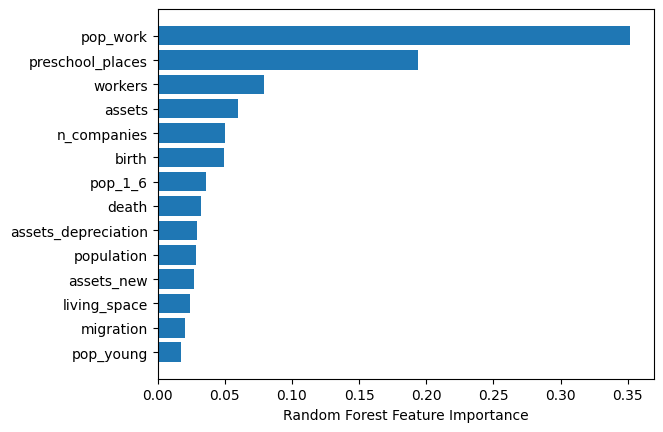

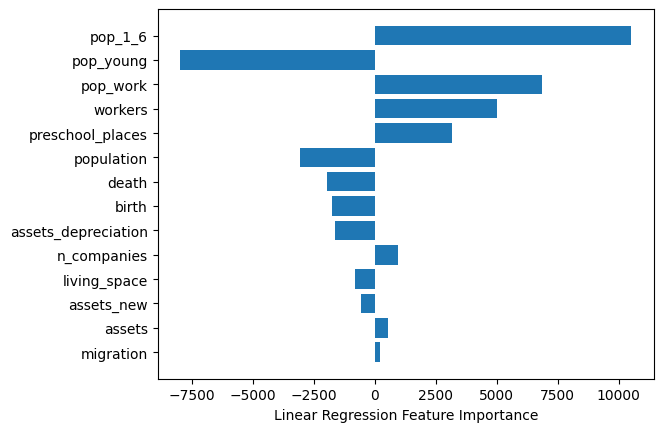

In [144]:
feature_importance = best_RF.feature_importances_
feature_names = X_train_scaled.columns
sorted_idx = feature_importance.argsort()
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

coefs = lr.coef_
sorted_abs = abs(coefs).argsort()
plt.barh(feature_names[sorted_abs], coefs[sorted_abs])
plt.xlabel("Linear Regression Feature Importance")
plt.show()

Обе модели активно используют показатели демографической структуры (доля разных возрастных групп в общей численности) и почти не обращают внимание на миграцию населения.
Причины влияния демографической структуры предполагал в первом дз.
Дерево классификации выглядит более логично для взгляда социально-экономического географа, находя связь высокой зарплаты с высокой долей населения в рабочем возрасте, низкой безработицей и высоким числом компаний на душу населения (город может предложить рабочие места).

Регрессия говорит о более значимой важности факторов доли детей 1-6 и молодого населения (до 18 лет) - с разными знаками!
Эту ситуацию можно объяснить, но уже зная специфику городов России:
города с высокой долей молодого населения, как правило, находятся в слабоурбанизированных регионах (Северный Кавказ, республики Сибири) - где демографический переход совершён не полностью.
В то время как высокая доля малышей до 6 лет может быть связана с притоком работоспособного молодого населения в город, которые приезжают семьями и заводят детей в силу возраста (самый яркий пример - нефтедобывающие регионы Западной Сибири, где из-за миграций молодых работников уменьшается средний возраст, растёт рождаемость).

Слабая зависимость от миграции меня удивляет (ведь высокие зарплаты обычно привлекают население - возможно, без учёта данных двух российских "столиц" этот эффект очень мал сам по себе)

In [109]:
RF_better = pd.DataFrame()
LR_better = pd.DataFrame()
RF_preds = best_RF.predict(X_test_scaled)
LR_preds = lr.predict(X_test_scaled)
for i in range(len(RF_preds)):
    if abs(RF_preds[i] - y_test.iloc[i]) <= abs(LR_preds[i] - y_test.iloc[i]):
        RF_better = RF_better.append(clean1.iloc[i])
    else:
        LR_better = LR_better.append(clean1.iloc[i])

In [111]:
RF_preds = best_RF.predict(X_train_scaled)
LR_preds = lr.predict(X_train_scaled)
for i in range(len(RF_preds)):
    if abs(RF_preds[i] - y_train.iloc[i]) <= abs(LR_preds[i] - y_train.iloc[i]):
        RF_better = RF_better.append(clean1.iloc[i])
    else:
        LR_better = LR_better.append(clean1.iloc[i])

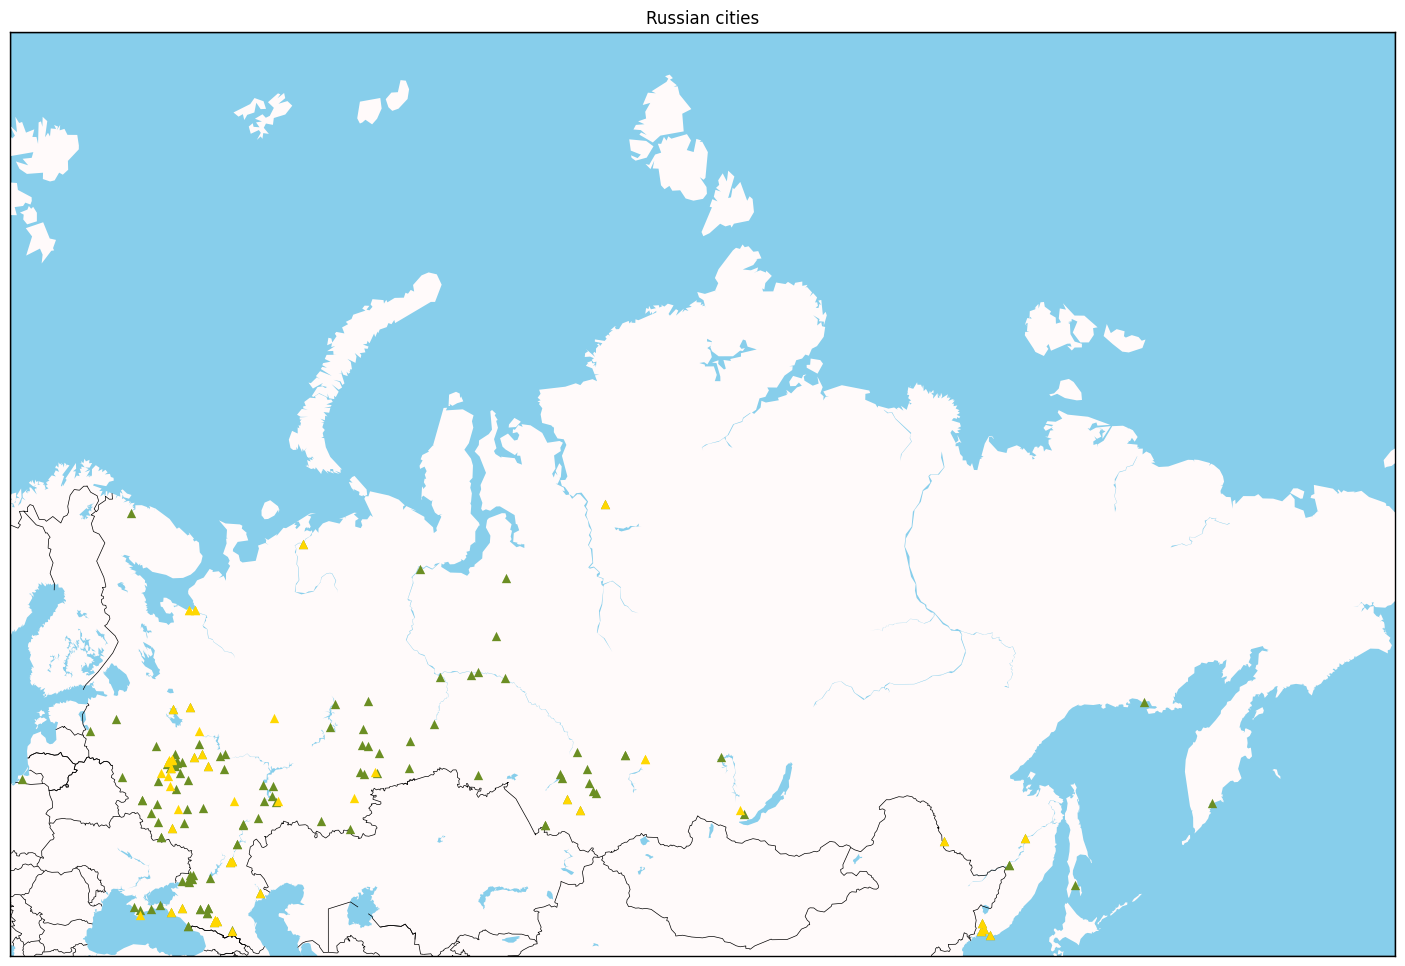

In [112]:
plt.figure(1, figsize=(20,12))

# Mercator of World
m1 = Basemap(
    projection='merc',
    llcrnrlat=41,  # минимальная широта (юг)
    urcrnrlat=82,  # максимальная широта (север)
    llcrnrlon=19,  # минимальная долгота (запад)
    urcrnrlon=180,  # максимальная долгота (восток)
    lat_0=61,  # центральная широта
    lon_0=100,  # центральная долгота
    lat_ts=0,
    resolution='l',
)

m1.fillcontinents(color='#FFFAFA',lake_color='#87CEEB') # dark grey land, black lakes
m1.drawmapboundary(fill_color='#87CEEB')                # black background
m1.drawcountries(linewidth=0.5, color="#000000")        # thin white line for country borders


xxy = m1(RF_better["longitude_dd"].tolist(), RF_better["latitude_dd"].tolist())
m1.scatter(xxy[0], xxy[1], s=45, c="#6B8E23", lw=0, alpha=1, zorder=2, marker = '^')

xxy = m1(LR_better["longitude_dd"].tolist(), LR_better["latitude_dd"].tolist())
m1.scatter(xxy[0], xxy[1], s=45, c="#FFD700", lw=0, alpha=1, zorder=2, marker = '^')

plt.title("Russian cities")
plt.savefig('map.png', dpi=100)
plt.show()

Можно заметить, что явной географической зависимости мы заметить не можем.
Однако, наше подобранное дерево регрессии лучше определяет зарплаты в некоторых регионах:
Малые и средние города средней полосы (без спутников Москвы и крупных городов)
Города Поволжья, Урала, Западной Сибири
могу предположить, что их показатели схожи между собой, общее описание этих городов правилами могло точнее описать средние зарплаты.

Регрессия же лучше вычисляет среднюю зарплату для "уникальных" городов, с возможными выбросами показателей и уникальными характеристиками, которые сложнее поддаются правилам - крупнейшие города регионов

In [131]:
models = [LinearRegression(), RandomForestRegressor(max_depth=29, n_estimators=100, random_state=2024)]
preds = []
for model in models:
  model.fit(X_train_scaled, y_train)
  preds.append(model.predict(X_test_scaled))
y_preds = np.array(preds).mean(axis=0)
print(f'RMSE for best: {mean_squared_error(y_test, y_preds, squared=False)}')
print(f'R2 score for best: {r2_score(y_test, y_preds)}')

RMSE for best: 10565.62752955579
R2 score for best: 0.7727107704551531


"Поженив" две лучшие модели, мы получаем лучшую метрику. Спасибо большое Вам за курс!